In [10]:
import os
import pyciemss
import torch
import pandas as pd
import numpy as np
from typing import Dict, List, Callable

import pyciemss.visuals.plots as plots
import pyciemss.visuals.vega as vega
import pyciemss.visuals.trajectories as trajectories

from pyciemss.integration_utils.intervention_builder import (
    param_value_objective,
    start_time_objective,
)

import json
from mira.metamodel import *
from mira.modeling.amr.petrinet import template_model_to_petrinet_json
from mira.sources.amr.petrinet import template_model_from_amr_json



smoke_test = ('CI' in os.environ)

In [23]:
# stratified model is numerically unstable due to stiffness
# so we use model b 

# here we try to test for instability by changing parameters
with open("sir_3strain_petrinet_revised.json", 'r') as fh:
    tm = template_model_from_amr_json(json.load(fh))

for par in tm.parameters:
    #print(par, tm.parameters[par].value)

    if par.startswith("gamma"):
        tm.parameters[par].value = 0.2
    if par.startswith("beta"):
        tm.parameters[par].value = 0.1

with open("sir_3strain_petrinet_revised_params.json", 'w') as fh:
    json.dump(template_model_to_petrinet_json(tm), fh, indent=1)

for par in tm.parameters:
    print(par, tm.parameters[par].value)

beta_0 0.1
beta_1 0.1
beta_2 0.1
gamma_0 0.2
gamma_1 0.2
gamma_2 0.2
beta_alpha_delta 0.1
gamma_delta 0.2
beta_alpha_alpha_delta 0.1
gamma_alpha_delta 0.2
beta_alpha_omicron_delta 0.1
gamma_omicron_delta 0.2
beta_alpha_alpha_omicron_delta 0.1
gamma_alpha_omicron_delta 0.2
beta_omicron_delta 0.1
beta_omicron_alpha_delta 0.1
beta_omicron_omicron_delta 0.1
beta_omicron_alpha_omicron_delta 0.1
beta_alpha_omicron_alpha_delta 0.1
beta_alpha_omicron_omicron_delta 0.1
beta_alpha_omicron_alpha_omicron_delta 0.1
beta_delta_alpha 0.1
gamma_alpha 0.2
beta_delta_delta_alpha 0.1
gamma_delta_alpha 0.2
beta_delta_omicron_alpha 0.1
gamma_omicron_alpha 0.2
beta_delta_delta_omicron_alpha 0.1
gamma_delta_omicron_alpha 0.2
beta_omicron_alpha 0.1
beta_omicron_delta_alpha 0.1
beta_omicron_omicron_alpha 0.1
beta_omicron_delta_omicron_alpha 0.1
beta_delta_omicron_delta_alpha 0.1
beta_delta_omicron_omicron_alpha 0.1
beta_delta_omicron_delta_omicron_alpha 0.1
beta_alpha_omicron 0.1
gamma_omicron 0.2
beta_alpha_a

In [37]:
# two models are unstable 
# as some compartment sizes 
# are orders of magnitude smaller than others

#model = "sir_3strain_petrinet_revised.json"
#model = "sir_3strain_petrinet_revised_params.json"

model = "scenario1_model_b_petrinet.json"

In [46]:
# setting distributions for parameters to make interventions possible
with open(model, 'r') as fh:
    tm = template_model_from_amr_json(json.load(fh))

tm.parameters['beta'].distribution = Distribution(type='StandardUniform1',
                                                 parameters={'minimum': 0.3, 'maximum': 0.5})

with open("scenario1_model_b_petrinet_distro.json", 'w') as fh:
    json.dump(template_model_to_petrinet_json(tm), fh, indent=1)

model = "scenario1_model_b_petrinet_distro.json"

In [48]:
start_time = 0.0
end_time = 62.0
logging_step_size = 1.0
num_samples =  100

In [49]:
result = pyciemss.sample(model, end_time, logging_step_size, num_samples)
display(result['data'].head())

,timepoint_id,sample_id,timepoint_unknown,persistent_beta_param,b_state,i_state,r_state,s_state
0,0,0,1.0,0.375406,0.000132,0.001261,0.000029,0.998578
1,1,0,2.0,0.375406,0.000252,0.001590,0.000112,0.998046
2,2,0,3.0,0.375406,0.000374,0.002004,0.000246,0.997376
3,3,0,4.0,0.375406,0.000508,0.002526,0.000434,0.996532
4,4,0,5.0,0.375406,0.000664,0.003182,0.000685,0.995469


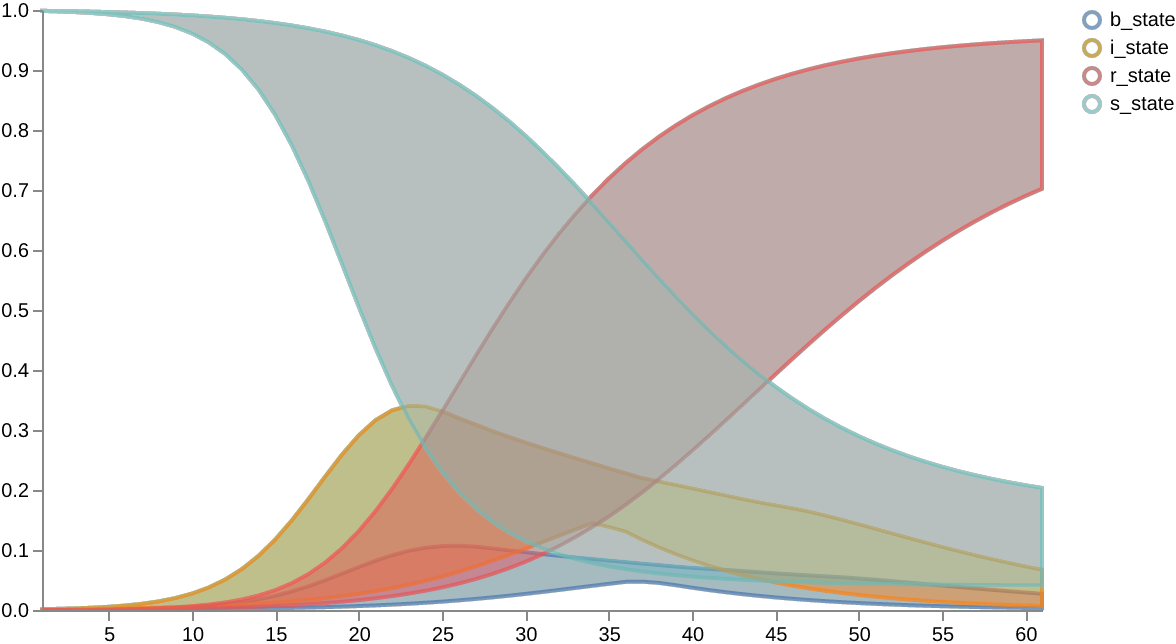

In [50]:
schema = plots.trajectories(result["data"], keep=".*_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

In [51]:
static_parameter_interventions = {
    torch.tensor(10.0):
    {"beta": lambda x: x * .5}   # decrease the rate by half
     }


result_beta_intervened = pyciemss.sample(model, end_time, logging_step_size, num_samples,
                         static_parameter_interventions=static_parameter_interventions)

display(result_beta_intervened['data'].head())


,timepoint_id,sample_id,timepoint_unknown,persistent_beta_param,b_state,i_state,r_state,s_state
0,0,0,1.0,0.445692,0.000137,0.001353,0.000030,0.998480
1,1,0,2.0,0.445692,0.000275,0.001829,0.000118,0.997778
2,2,0,3.0,0.445692,0.000430,0.002473,0.000268,0.996829
3,3,0,4.0,0.445692,0.000619,0.003342,0.000492,0.995548
4,4,0,5.0,0.445692,0.000861,0.004513,0.000807,0.993818


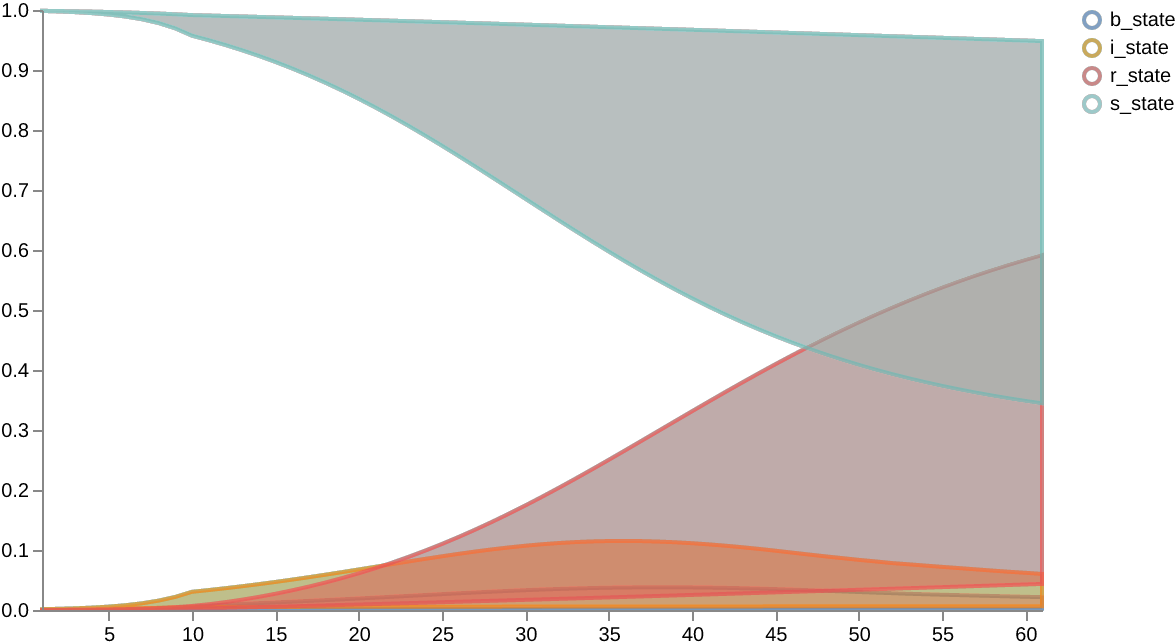

In [53]:
schema_beta_intervened = plots.trajectories(result_beta_intervened["data"], keep=".*_state")
plots.save_schema(schema_beta_intervened, "_schema.json")
plots.ipy_display(schema_beta_intervened, dpi=150)

In [59]:
def intervention_function(state) -> Dict[str, torch.Tensor]:
    extracted = state['i'] * .1
    new_state = state.copy()
    new_state['i'] = state['i'] - extracted
    new_state['b'] = state['b'] + extracted
    return new_state


static_state_interventions = {
    torch.tensor(20.0): 
    {
    "i":  lambda x: x * .7,
    }
       # remove 30% infected out of the system (intuition: quarantine)
     }


In [60]:

result_state_intervened = pyciemss.sample(model, end_time, logging_step_size, num_samples,
                         static_state_interventions=static_state_interventions)

display(result_state_intervened['data'].head())

,timepoint_id,sample_id,timepoint_unknown,persistent_beta_param,b_state,i_state,r_state,s_state
0,0,0,1.0,0.372105,0.000132,0.001257,0.000029,0.998583
1,1,0,2.0,0.372105,0.000251,0.001580,0.000111,0.998058
2,2,0,3.0,0.372105,0.000372,0.001985,0.000245,0.997399
3,3,0,4.0,0.372105,0.000503,0.002493,0.000432,0.996572
4,4,0,5.0,0.372105,0.000656,0.003130,0.000680,0.995534


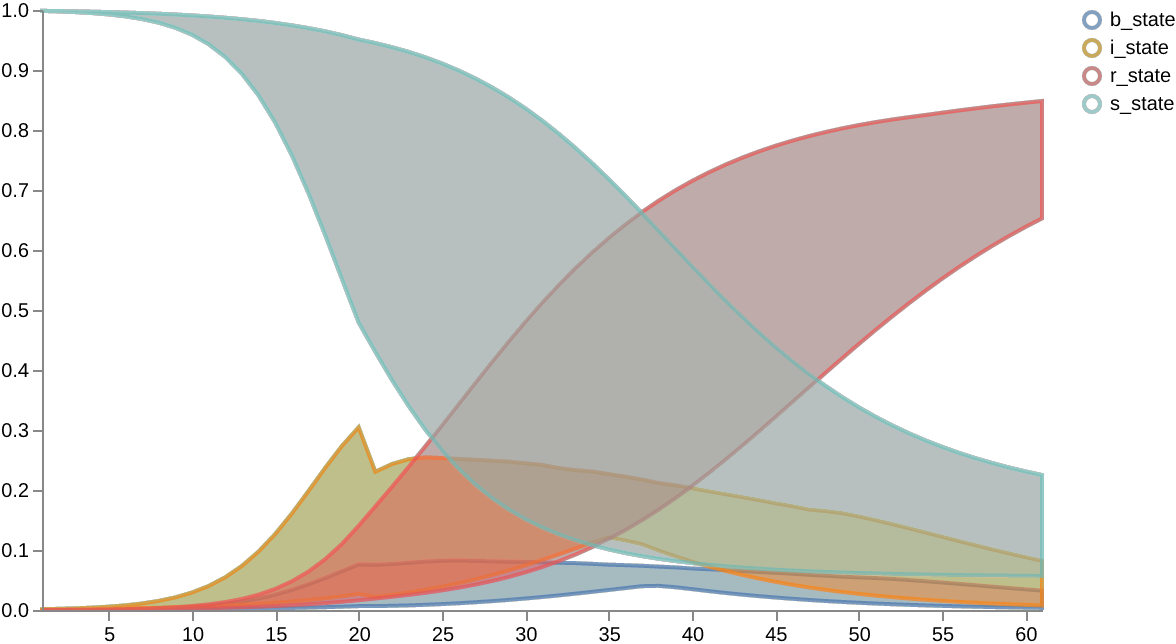

In [61]:
schema_state_intervened = plots.trajectories(result_state_intervened["data"], keep=".*_state")
plots.save_schema(schema_state_intervened, "_schema.json")
plots.ipy_display(schema_state_intervened, dpi=150)